In [ ]:
!conda install -y tensorboard

In [1]:
# load the TensorBoard notebook extension
%load_ext tensorboard

### Imports

In [2]:
import cv2

In [3]:
import os 

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler

In [4]:
import torchvision
import albumentations as A

from albumentations.pytorch import ToTensorV2

In [5]:
import lightning as pl

from torchmetrics.functional import accuracy
from lightning.pytorch.callbacks import LearningRateMonitor

### Create the ISBI segmentation data set

We are using the ISBI image segmentation data set from http://brainiac2.mit.edu/isbi_challenge/ (with ground truth test labels extracted from here https://github.com/a-martyn/unet/tree/master/data/membrane/test/target so we don't have to upload to the competition to check how we are doing).

In [6]:
class SegmentationDataset(Dataset):
    
    def __init__(self, root_dir, transforms=None):
        
        self.ids  = os.listdir(root_dir + 'images/')
        self.imgs = [os.path.join(root_dir, 'images/', i) for i in self.ids]
        self.mask = [os.path.join(root_dir, 'masks/', i) for i in self.ids]
        
        self.transforms = transforms
                
    
    # get a single item from the data set
    def __getitem__(self, idx):
        
        # read image and mask data (both grayscale here)
        image = cv2.imread(self.imgs[idx], 0)
        masks = cv2.imread(self.mask[idx], 0)
        
        # make mask data either 0 or 1 (rather than 0 or 255)
        masks = masks // 255
        
        # note: in some use cases the pixel value of our mask might denote
        # the class value, so we'd have to remove the line above
        
        # store in our sample dictionary
        sample = {'image': image, 
                  'mask': masks}
        
        # apply any transforms
        if self.transforms:
            new = self.transforms(image=sample['image'], mask=sample['mask'])
            sample['image'] = new['image']
            sample['mask'] = new['mask']
            
        return sample
    
    
    # get the length of the data set
    def __len__(self):
        return len(self.ids)

### Create an ISBI data module

This is based on the lightning data module and handles reading / preparing the dataset and creating the data loaders for training and validation.
See https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html#lightningdatamodule-api

In [7]:
class ISBI_data_module(pl.LightningDataModule):
    
    def __init__(self,
                 data_dir: str = './data/',
                 batch_size: int = 2,
                 num_workers: int = 8,
                 train_samples=None,
                 valid_samples=None
                ):
        
        # what this does is make sure we call all the methods in the right 
        # order - see https://stackoverflow.com/a/27134600
        super().__init__()
        
        # specify where to save the data and how to load it (e.g. batch size, 
        # how many workers to use when loading the data, etc.)
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # specify key information about the dataset
        self.dims = (1, 512, 512)
        self.num_classes = 1
        
        # get the number of samples to use in training and validation
        self.train_samples = train_samples
        self.valid_samples = valid_samples
        
        # initialise the specified default train and test transforms
        self._set_default_transforms()
        
    
    # get the data sets for train and val/test
    def setup(self, stage=None):
        
        # load the datasets :)
        self.train_dataset = SegmentationDataset(self.data_dir + 'train/', transforms=self.train_transform)
        self.test_dataset = SegmentationDataset(self.data_dir + 'test/', transforms=self.test_transform)
        
        # set the training and validation samplers
        if self.train_samples:
            self.train_sampler = RandomSampler(self.train_dataset, replacement=True, num_samples=self.train_samples * self.batch_size)
        else:
            self.train_sampler = None
            
        if self.valid_samples:
            self.valid_sampler = RandomSampler(self.test_dataset, replacement=True, num_samples=self.valid_samples * self.batch_size)
        else:
            self.train_sampler = None
        
    
    # get the data loaders ...
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, sampler=self.train_sampler)    
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, sampler=self.valid_sampler)    
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)    
        
    
    # set up the default training and testing transforms using albumentations - which
    # does a better job of image transforms for segmentation tasks
    def _set_default_transforms(self):    
        
        # for training we use elastic transformations and some shifting and rotations
        self.train_transform = A.Compose([
        
            # these are - as best as i can manage - the same as in the keras example
            
            # mess with the image scales (random crops, rotations, etc.)
            A.Affine(shear=0.05, p=1.0),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=2, p=1.0),
            A.HorizontalFlip(p=1.0),
            
            # applying brightness and contrast adjustments (using the defaults)
            A.RandomBrightnessContrast(p=1.0),

            # normalise the image and convert both image and mask to tensors
            A.Normalize(mean=(0), std=(1)),
            A.pytorch.ToTensorV2()
        ])

        # for the test data we just convert to a tensor (which also rescales to 0 - 1)
        self.test_transform = A.Compose([
            A.PadIfNeeded(512, 512),
            
            # normalise the image and convert both image and mask to tensors
            A.Normalize(mean=(0), std=(1)),
            A.pytorch.ToTensorV2()
        ])  

### Test the data module

Let's grab an image out of the data module to see what it looks like.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# helper function for data visualisation
def visualize(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        
        # display in grayscle because our ISBI data is grayscale
        plt.imshow(image, cmap='gray', vmin=0, vmax=1)
        
    plt.show()

In [9]:
batch_size = 2
test_data = ISBI_data_module(data_dir='./data/isbi_segmentation_dataset/', batch_size=batch_size)
test_data.setup()

test_batch = next(iter(test_data.train_dataloader()))

In [10]:
print(test_batch['mask'].shape)

torch.Size([2, 512, 512])


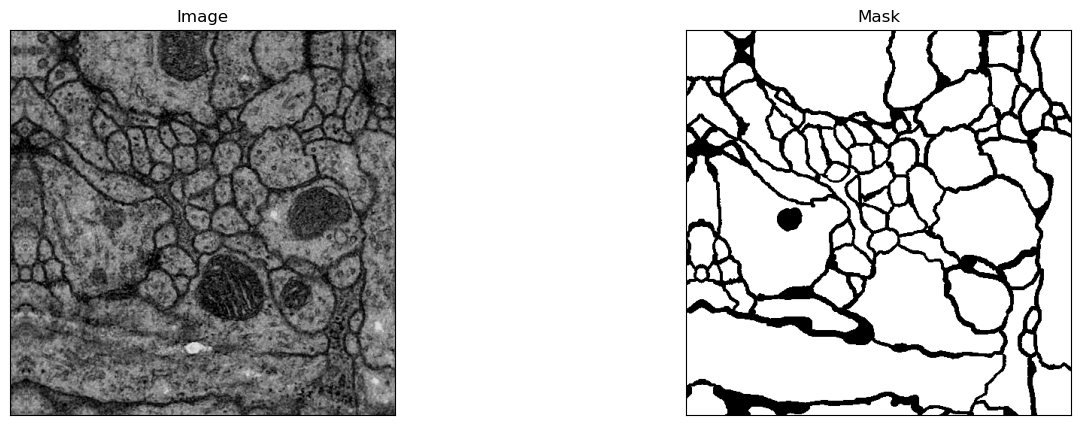

In [11]:
visualize(image=test_batch['image'].squeeze()[0], mask=test_batch['mask'].squeeze()[0])

In [12]:
print(np.unique(test_batch['mask'].squeeze()[0]))

[0 1]


In [13]:
test_batch['mask'][0].shape

torch.Size([512, 512])

### Get the UNet model and wrap it in a lightning module

I'm wrapping my version of the UNet model in a lightning module so we can use pytorch-lightning for training.
See: https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.lightning.html#module-pytorch_lightning.core.lightning

In [14]:
from unet_model_dropout import UNet

In [15]:
class LightningUNet(pl.LightningModule):
    
    def __init__(self, batch_size=2, lr=1e-4):
        super().__init__()
        self.batch_size = batch_size
        self.save_hyperparameters()
        self.model = UNet(num_classes=2,
                          enc_channels=[1, 64, 128, 256, 512, 1024],
                          dec_channels=[1024, 512, 256, 128, 64])
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['mask']
        
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat.squeeze(), y.squeeze().long())
        self.log('train_loss', loss)
        return loss

    def evaluate(self, batch, stage=None):
        
        x, y = batch['image'], batch['mask']      
        y_hat = self.forward(x)
        
        loss = F.cross_entropy(y_hat.squeeze(), y.squeeze().long())
        
        preds = torch.argmax(y_hat.squeeze(), dim=1)
        acc = accuracy(preds, y, task='binary')

        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_acc', acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, 'val')

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, 'test')

    # set up the optimisers
    def configure_optimizers(self):
                
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)        
        
        scheduler_dict = {
            'scheduler': ReduceLROnPlateau(optimizer, patience=0, verbose=True),
            'monitor': 'val_loss'
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_dict}
        

### Run the training process

We can also launch tensorboard before starting training to visualise the training process as it happens.

In [16]:
# let's monitor training as it happens
%tensorboard --logdir lightning_logs

In [17]:
batch_size = 2

data = ISBI_data_module(data_dir='./data/isbi_segmentation_dataset/', batch_size=batch_size, train_samples=500)

model = LightningUNet(batch_size=batch_size, lr=1e-4)
model.datamodule = data

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    logger=pl.pytorch.loggers.TensorBoardLogger('lightning_logs/', name='unet'),
    callbacks=[LearningRateMonitor(logging_interval='step')],
)

trainer.fit(model, data)
trainer.test(model, datamodule=data);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 4000 SFF Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/alex/code/development_tools/anaconda3/envs/lightning-segmentation/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 31.0 M | train
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.123   Tot

Sanity Checking: |                                                                      | 0/? [00:00<?, ?it/s]

/home/alex/code/development_tools/anaconda3/envs/lightning-segmentation/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 0: 100%|█████████████████████████████████████████████████████| 500/500 [01:43<00:00,  4.83it/s, v_num=2]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████| 500/500 [01:46<00:00,  4.70it/s, v_num=2, val_loss=0.379, val_acc=0.801]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████| 500/500 [01:46<00:00,  4.69it/s, v_num=2, val_loss=0.321, val_acc=0.844]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████| 500/500 [01:47<00:00,  4.66it/s, v_num=2, val_loss=0.195, val_acc=0.917]
Validation: |                                                                           | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████| 500/500 [01:46<00:00,  4.68it/s, v_num=2, val_loss=0.174, val_acc=0.931]
V

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████| 500/500 [01:56<00:00,  4.31it/s, v_num=2, val_loss=0.195, val_acc=0.931]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9318494200706482
        test_loss           0.19436822831630707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Make a couple of predictions

In [19]:
batch_size = 2
test_data = ISBI_data_module(data_dir='./data/isbi_segmentation_dataset/', batch_size=batch_size)
test_data.setup()
test_batch = next(iter(test_data.test_dataloader()))

In [21]:
pred = model(test_batch['image'])
predicted_mask = torch.argmax(pred.squeeze(), dim=1).cpu().detach().numpy()

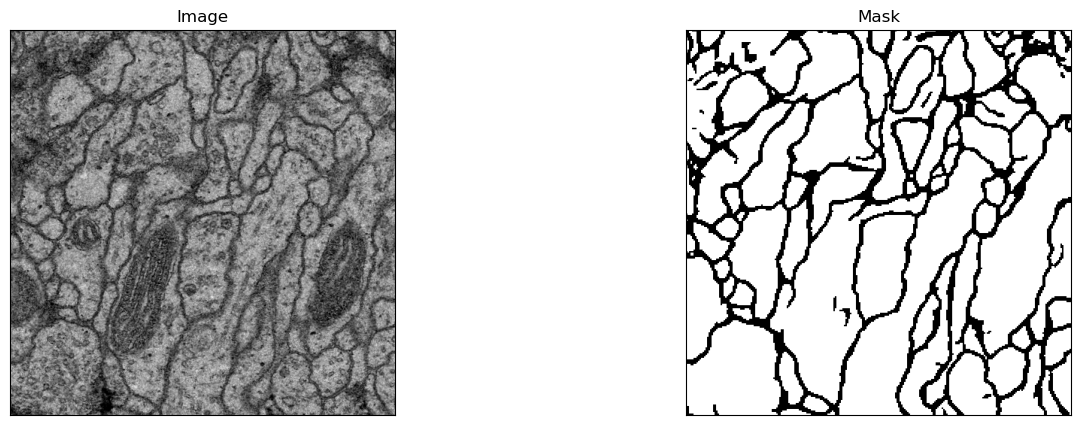

In [22]:
visualize(image=test_batch['image'][0].squeeze(), mask=test_batch['mask'][0].squeeze())

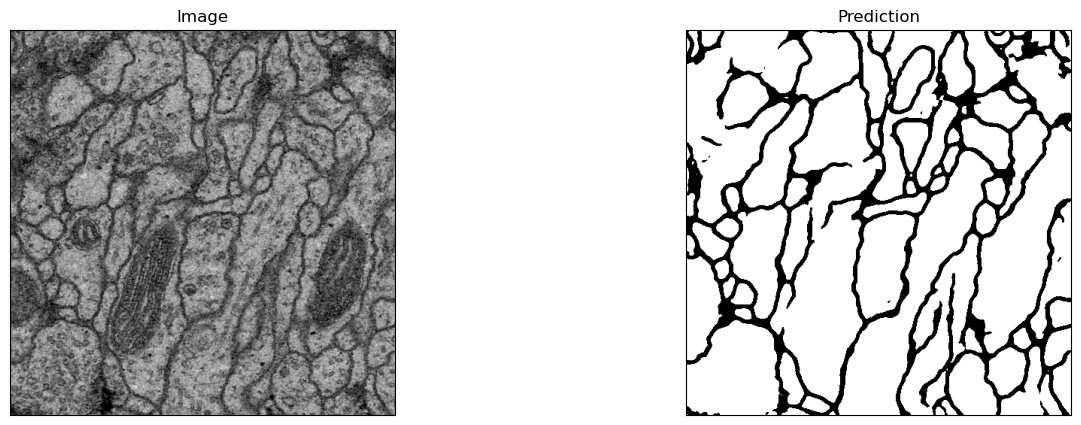

In [23]:
visualize(image=test_batch['image'][0].squeeze(), prediction=predicted_mask[0].squeeze())

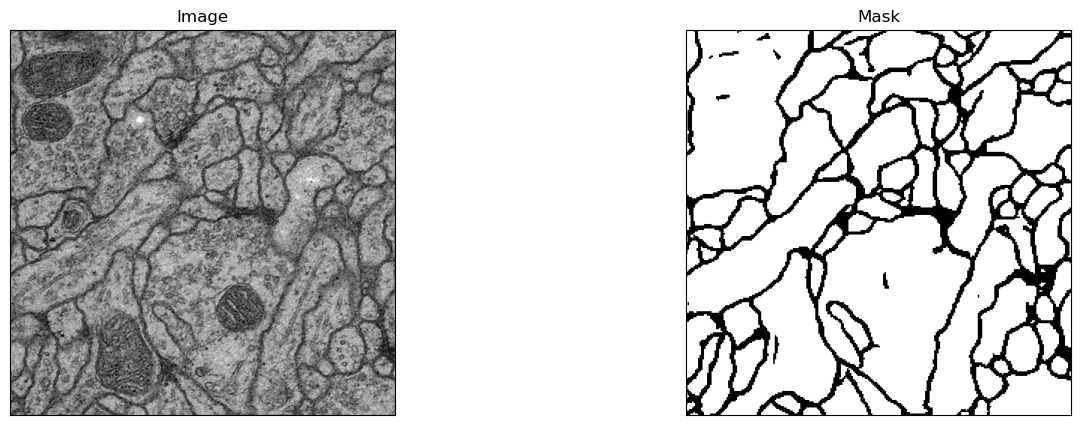

In [24]:
visualize(image=test_batch['image'][1].squeeze(), mask=test_batch['mask'][1].squeeze())

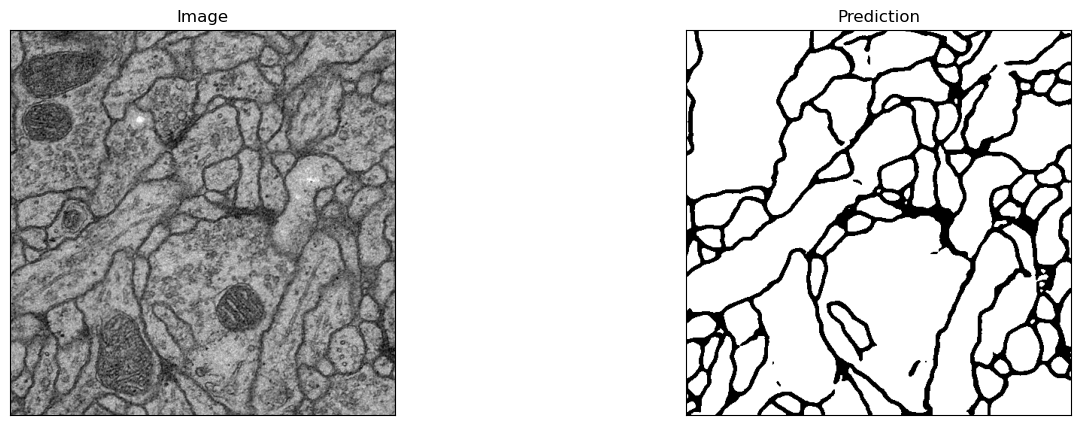

In [25]:
visualize(image=test_batch['image'][1].squeeze(), prediction=predicted_mask[1].squeeze())

### Looks pretty good to me :)